In [14]:
import numpy as np
import pandas as pd
import pickle
from sentence_transformers import SentenceTransformer, util
import re

In [ ]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')

In [6]:
with open('./question-context-20.pkl', 'rb') as f:
    df_20 = pickle.load(f)
df_20.reset_index(inplace=True)

In [8]:
with open('./context_embeddings.pkl', 'rb') as f:
    context_embeddings = pickle.loads(f.read())
with open('./question_embeddings.pkl', 'rb') as f:
    question_embeddings = pickle.loads(f.read())

In [9]:
from collections import defaultdict

is_added = defaultdict(lambda: 0)

contexts = df_20['context'].unique()
data = []

for i,row in df_20.iterrows():
    if is_added[row['question']]:
        continue

    dft = pd.DataFrame(columns=['context', 'question', 'label'])
    dft['context'] = contexts
    dft['question'] = row['question']
    dft['label'] = 0

    for ctx in df_20.loc[df_20['question'] == row['question'],'context']:
        dft.loc[dft['context']==ctx,'label'] = 1

    data.append(dft)

    is_added[row['question']] = 1
df = pd.concat(data, ignore_index=True)
sum(df['label'])

3198

In [118]:
sentences = [s for c in contexts for s in re.split('\. |\? |\! ', c)]
sentences = [s for s in sentences if len(s)>10]

In [121]:
sentence_embeddings = {s: model.encode(s) for s in sentences}

In [122]:
n_test_q = int(0.25*len(df['question'].unique()))
test_q = np.random.choice(df['question'].unique(), n_test_q, replace=False)

n_test_ctx = int(0.25*len(df['context'].unique()))
test_ctx = np.random.choice(df['context'].unique(), n_test_ctx, replace=False)

df_test = df.loc[df['question'].isin(test_q)].loc[df['context'].isin(test_ctx)]
df_test.reset_index(inplace=True, drop=True)
df_train = df.loc[~df['question'].isin(test_q)].loc[~df['context'].isin(test_ctx)]
df_train.reset_index(inplace=True, drop=True)

df_test_all_ctx = df.loc[df['question'].isin(test_q)]
df_test_all_ctx.reset_index(inplace=True, drop=True)
df_train_all_ctx =  df.loc[~df['question'].isin(test_q)]
df_train_all_ctx.reset_index(inplace=True, drop=True)

X_train = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train['context'].values, df_train['question'].values)])
y_train = np.array([i for i in df_train['label'].values])

X_test = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test['context'].values, df_test['question'].values)])
y_test = np.array([i for i in df_test['label'].values])


X_train_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_train_all_ctx['context'].values, df_train_all_ctx['question'].values)])
y_train_all_ctx = np.array([i for i in df_train_all_ctx['label'].values])

X_test_all_ctx = np.array([np.concatenate((context_embeddings[ctx],question_embeddings[q])) for ctx,q in zip(df_test_all_ctx['context'].values, df_test_all_ctx['question'].values)])
y_test_all_ctx = np.array([i for i in df_test_all_ctx['label'].values])

idx_train = np.random.permutation(len(X_train))
X_train = X_train[idx_train]
y_train = y_train[idx_train]

idx_test = np.random.permutation(len(X_test))
X_test = X_train[idx_test]
y_test = y_train[idx_test]

idx_train_all_ctx = np.random.permutation(len(X_train_all_ctx))
X_train_all_ctx = X_train_all_ctx[idx_train_all_ctx]
y_train_all_ctx = y_train_all_ctx[idx_train_all_ctx]

idx_test_all_ctx = np.random.permutation(len(X_test_all_ctx))
X_test_all_ctx = X_test_all_ctx[idx_test_all_ctx]
y_test_all_ctx = y_test_all_ctx[idx_test_all_ctx]

In [123]:
data = [{'sentence':s, 'question':q, 'score':np.dot(sentence_embeddings[s],question_embeddings[q])} for s in sentences for q in test_q]
df_voting_score = pd.DataFrame(columns=['sentence', 'question', 'score'], data=data)

In [48]:
from tqdm import tqdm

In [166]:
df_test_all_ctx['prediction'] = 0
for q in tqdm(test_q):
    votes = {c:0 for c in contexts}
    top_100_s = df_voting_score.loc[df_voting_score['question']==q].sort_values(by='score',ascending=False).iloc[0:100]['sentence']
    for s in top_100_s:
        matches = [c for c in contexts if s in c]
        for m in matches:
            votes[m]+=1
    ctx = max(votes,key=votes.get)
    df_test_all_ctx.loc[(df_test_all_ctx['question'] == q) & (df_test_all_ctx['context'] == ctx), 'prediction'] = 1


C:\Users\Lauritz\AppData\Local\Temp\ipykernel_16596\21840545.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_all_ctx['prediction'] = 0
100%|██████████| 791/791 [05:17<00:00,  2.49it/s]


In [195]:
a = {"lel":1,"bla":2}
for k,v in a.items():
    print(k)

lel
bla


In [199]:
#df_test_all_ctx['prediction'] = 0
all_scores = []
for q in tqdm(test_q):
    scores = {c:0 for c in contexts}
    df_slice = df_voting_score.loc[df_voting_score['question']==q]
    q_score_sum = df_slice['score'].values.sum()
    for s,score in df_slice.sort_values(by='score', ascending=False).loc[:,['sentence','score']].values[:1000]:
        matches = [c for c in contexts if s in c]
        for m in matches:
            scores[m]+=score/q_score_sum
    all_scores.append(scores)
    # for c,s in scores.items():
    #     df_test_all_ctx.loc[(df_test_all_ctx['question'] == q) & (df_test_all_ctx['context'] == c), 'prediction']=score/q_score_sum

100%|██████████| 791/791 [10:10<00:00,  1.30it/s]


In [232]:
y = []
y_preds = []
i = 0
n_len = len(test_q)
for d,q in zip(all_scores,test_q):
    y+=df_test_all_ctx.loc[df_test_all_ctx['question']==q]['label'].to_list()
    y_preds+=d.values()

In [244]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=f'{name} AUC: {roc_auc_score(labels, predictions):.3f}', linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,100])
  plt.ylim([0,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

In [214]:
df_test_all_ctx.iloc[0]['context']

' How can we build intelligent machines? More than 65 years ago Alan Turing made this question the subject of his famous essay “Computing machinery and intelligence” [Turing, 1950]. Alan Turing suggested that when we phrase the question in this manner, we unavoidably get bogged down in the definition of the word “intelligence”. Instead, he proposed we should rather consider a different question: Can we construct a machine that can do the same things a human can do? This may ultimately be as hard to answer as the first question, but at least we don’t have to begin our efforts by defining intelligence. A second part of Turing’s essay discuss how we might build such a human\ufffeimitating machine. Turing proposed that instead of writing a computer program that behaves like a human from scratch, we should build a machine which initially cannot do a great many things but which can learn from past experience. For instance, if we wished to construct a machine which translate from English to F

In [167]:
y = df_test_all_ctx['label']
preds = df_test_all_ctx['prediction']

In [168]:
sum(y==preds)/len(y)

0.9910161188369153

In [169]:
sum(df_test_all_ctx['prediction'].values)

791

In [170]:
sum(df_test_all_ctx.loc[df_test_all_ctx['label']==1, 'prediction'].values)

224

In [246]:
y_cosine_preds = [np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b)) for a,b in zip(X_test_all_ctx[:,:1536//2], X_test_all_ctx[:,1536//2:])]

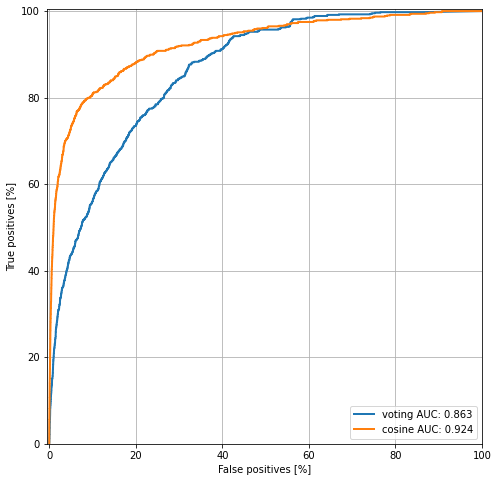

In [248]:
plt.figure(figsize=(16,8))
plot_roc("voting", y, y_preds)
plot_roc("cosine", y_test_all_ctx, y_cosine_preds)
plt.legend(loc='lower right')

In [153]:
y_cos = (np.array(y_cosine_preds)>0.5).astype(int)

In [171]:
sum(y_cos[y_test_all_ctx==1])

494